## DataSet Import

In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm

In [2]:
df_train = pd.read_csv('angles_train.csv')
df_val = pd.read_csv('angles_val.csv')
df_test = pd.read_csv('angles_test.csv')

In [3]:
df_train.shape, df_val.shape, df_test.shape

((56032, 23), (19259, 23), (4910, 23))

In [4]:
df_train['label'].unique()

array(['barbell biceps curl', 'bench press', 'chest fly machine',
       'deadlift', 'decline bench press', 'hammer curl', 'hip thrust',
       'incline bench press', 'lat pulldown', 'lateral raise',
       'leg extension', 'leg raises', 'plank', 'pull Up', 'push-up',
       'romanian deadlift', 'russian twist', 'shoulder press', 'squat',
       't bar row', 'tricep dips', 'tricep Pushdown', 'Sitting',
       'Walking', 'Standing Still'], dtype=object)

In [5]:
distinct_exercises = [
    'hammer curl',
    'deadlift',
    'lateral raise',
    'plank',
    'push-up',
    'russian twist',
    'squat',
    'shoulder press',
    'bench press',
    'Sitting',
    'Walking',
    'Standing Still'
]

df_train = df_train[df_train['label'].isin(distinct_exercises)]
df_val = df_val[df_val['label'].isin(distinct_exercises)]
df_test = df_test[df_test['label'].isin(distinct_exercises)]

In [6]:
df_train.shape, df_val.shape, df_test.shape

((28051, 23), (9380, 23), (2485, 23))

In [ ]:
def add_temporal_features(df):
    grouped = df.groupby('video_id')

    feature_cols = [col for col in df.columns if col not in ['video_id', 'label']]

    for col in feature_cols:
        # First derivative (velocity)
        df[f'{col}_vel'] = grouped[col].diff()

        # Second derivative (acceleration)
        df[f'{col}_acc'] = grouped[f'{col}_vel'].diff()

        # Jerk (rate of change of acceleration)
        df[f'{col}_jerk'] = grouped[f'{col}_acc'].diff()

    return df

df_train = add_temporal_features(df_train)
df_val = add_temporal_features(df_val)
df_test = add_temporal_features(df_test)

In [ ]:
def add_phase_features(df):
    # Identify exercise phases (concentric, eccentric, transition)
    grouped = df.groupby('video_id')

    # For key features, identify phases
    key_features = ['torso_lean', 'elbow_symmetry', 'hip_angle']

    for feature in key_features:
        # Calculate local minima and maxima to identify phases
        df[f'{feature}_local_min'] = grouped[feature].transform(
            lambda x: x == x.rolling(window=5, center=True).min()
        )
        df[f'{feature}_local_max'] = grouped[feature].transform(
            lambda x: x == x.rolling(window=5, center=True).max()
        )

        # Phase indicator (0: eccentric, 1: concentric, 2: transition)
        df[f'{feature}_phase'] = 0
        df.loc[df[f'{feature}_local_min'], f'{feature}_phase'] = 2  # Transition
        df.loc[df[f'{feature}_local_max'], f'{feature}_phase'] = 2  # Transition

        # Fill concentric phases
        for vid in df['video_id'].unique():
            vid_mask = df['video_id'] == vid
            vid_data = df[vid_mask].copy()

            # Find transitions and fill between them
            transitions = vid_data[vid_data[f'{feature}_phase'] == 2].index
            if len(transitions) >= 2:
                for i in range(0, len(transitions)-1, 2):
                    start_idx = transitions[i]
                    end_idx = transitions[i+1]
                    df.loc[vid_mask & (df.index >= start_idx) & (df.index <= end_idx), f'{feature}_phase'] = 1

    return df

In [ ]:
df_train = add_phase_features(df_train)
df_val = add_phase_features(df_val)
df_test = add_phase_features(df_test)

In [ ]:
df_train.shape, df_val.shape, df_test.shape

((50471, 95), (17848, 95), (4385, 95))

In [7]:
df_train['label'].value_counts()

,count
label,
plank,3347
squat,3317
Walking,3020
hammer curl,2919
Sitting,2654
push-up,2632
Standing Still,2295
deadlift,1879
bench press,1805


## Preprocessing

In [8]:
def clean_data(df):
    numeric_cols = df.select_dtypes(include=np.number).columns

    df[numeric_cols] = df.groupby('video_id')[numeric_cols].transform(
        lambda x: x.interpolate(method='linear', limit_direction='both')
    )

    df.fillna(method='ffill', inplace=True)
    df.fillna(method='bfill', inplace=True)
    return df

In [9]:
def remove_zero_frames(df):
    angle_cols = [col for col in df.columns if col not in ["label", "video_id", "Unnamed: 0"]]
    return df[(df[angle_cols].sum(axis=1) != 0)]

In [10]:
def clip_outliers_by_exercise(df):
    processed_groups = []
    grouped = df.groupby('label')

    for _, group in grouped:
        cols_to_process = group.select_dtypes(include=np.number).columns
        modified_group = group.copy()

        for column in cols_to_process:
            Q1 = modified_group[column].quantile(0.25)
            Q3 = modified_group[column].quantile(0.75)
            IQR = Q3 - Q1

            lower_bound = Q1 - 1.5 * IQR
            upper_bound = Q3 + 1.5 * IQR

            modified_group[column] = modified_group[column].clip(lower=lower_bound, upper=upper_bound)

        processed_groups.append(modified_group)

    return pd.concat(processed_groups, ignore_index=True)

In [11]:
def preprocess_dataset(df):
    df = clean_data(df)

    df = remove_zero_frames(df)

    df = clip_outliers_by_exercise(df)

    return df

In [12]:
df_train = preprocess_dataset(df_train)
df_val = preprocess_dataset(df_val)
df_test = preprocess_dataset(df_test)

/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='ffill', inplace=True)
/tmp/ipython-input-3759811462.py:9: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df.fillna(method='bfill', inplace=True)
/tmp/ipython-input-3759811462.py:8: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffil

In [13]:
df_train.shape, df_val.shape, df_test.shape

((28051, 23), (9380, 23), (2485, 23))

## Plotting

In [ ]:
from matplotlib import pyplot as plt
import seaborn as sns

In [ ]:
exercises = df_train['label'].unique()

In [ ]:
angle_columns = [col for col in df_train.columns if col not in ['label','video_id']]

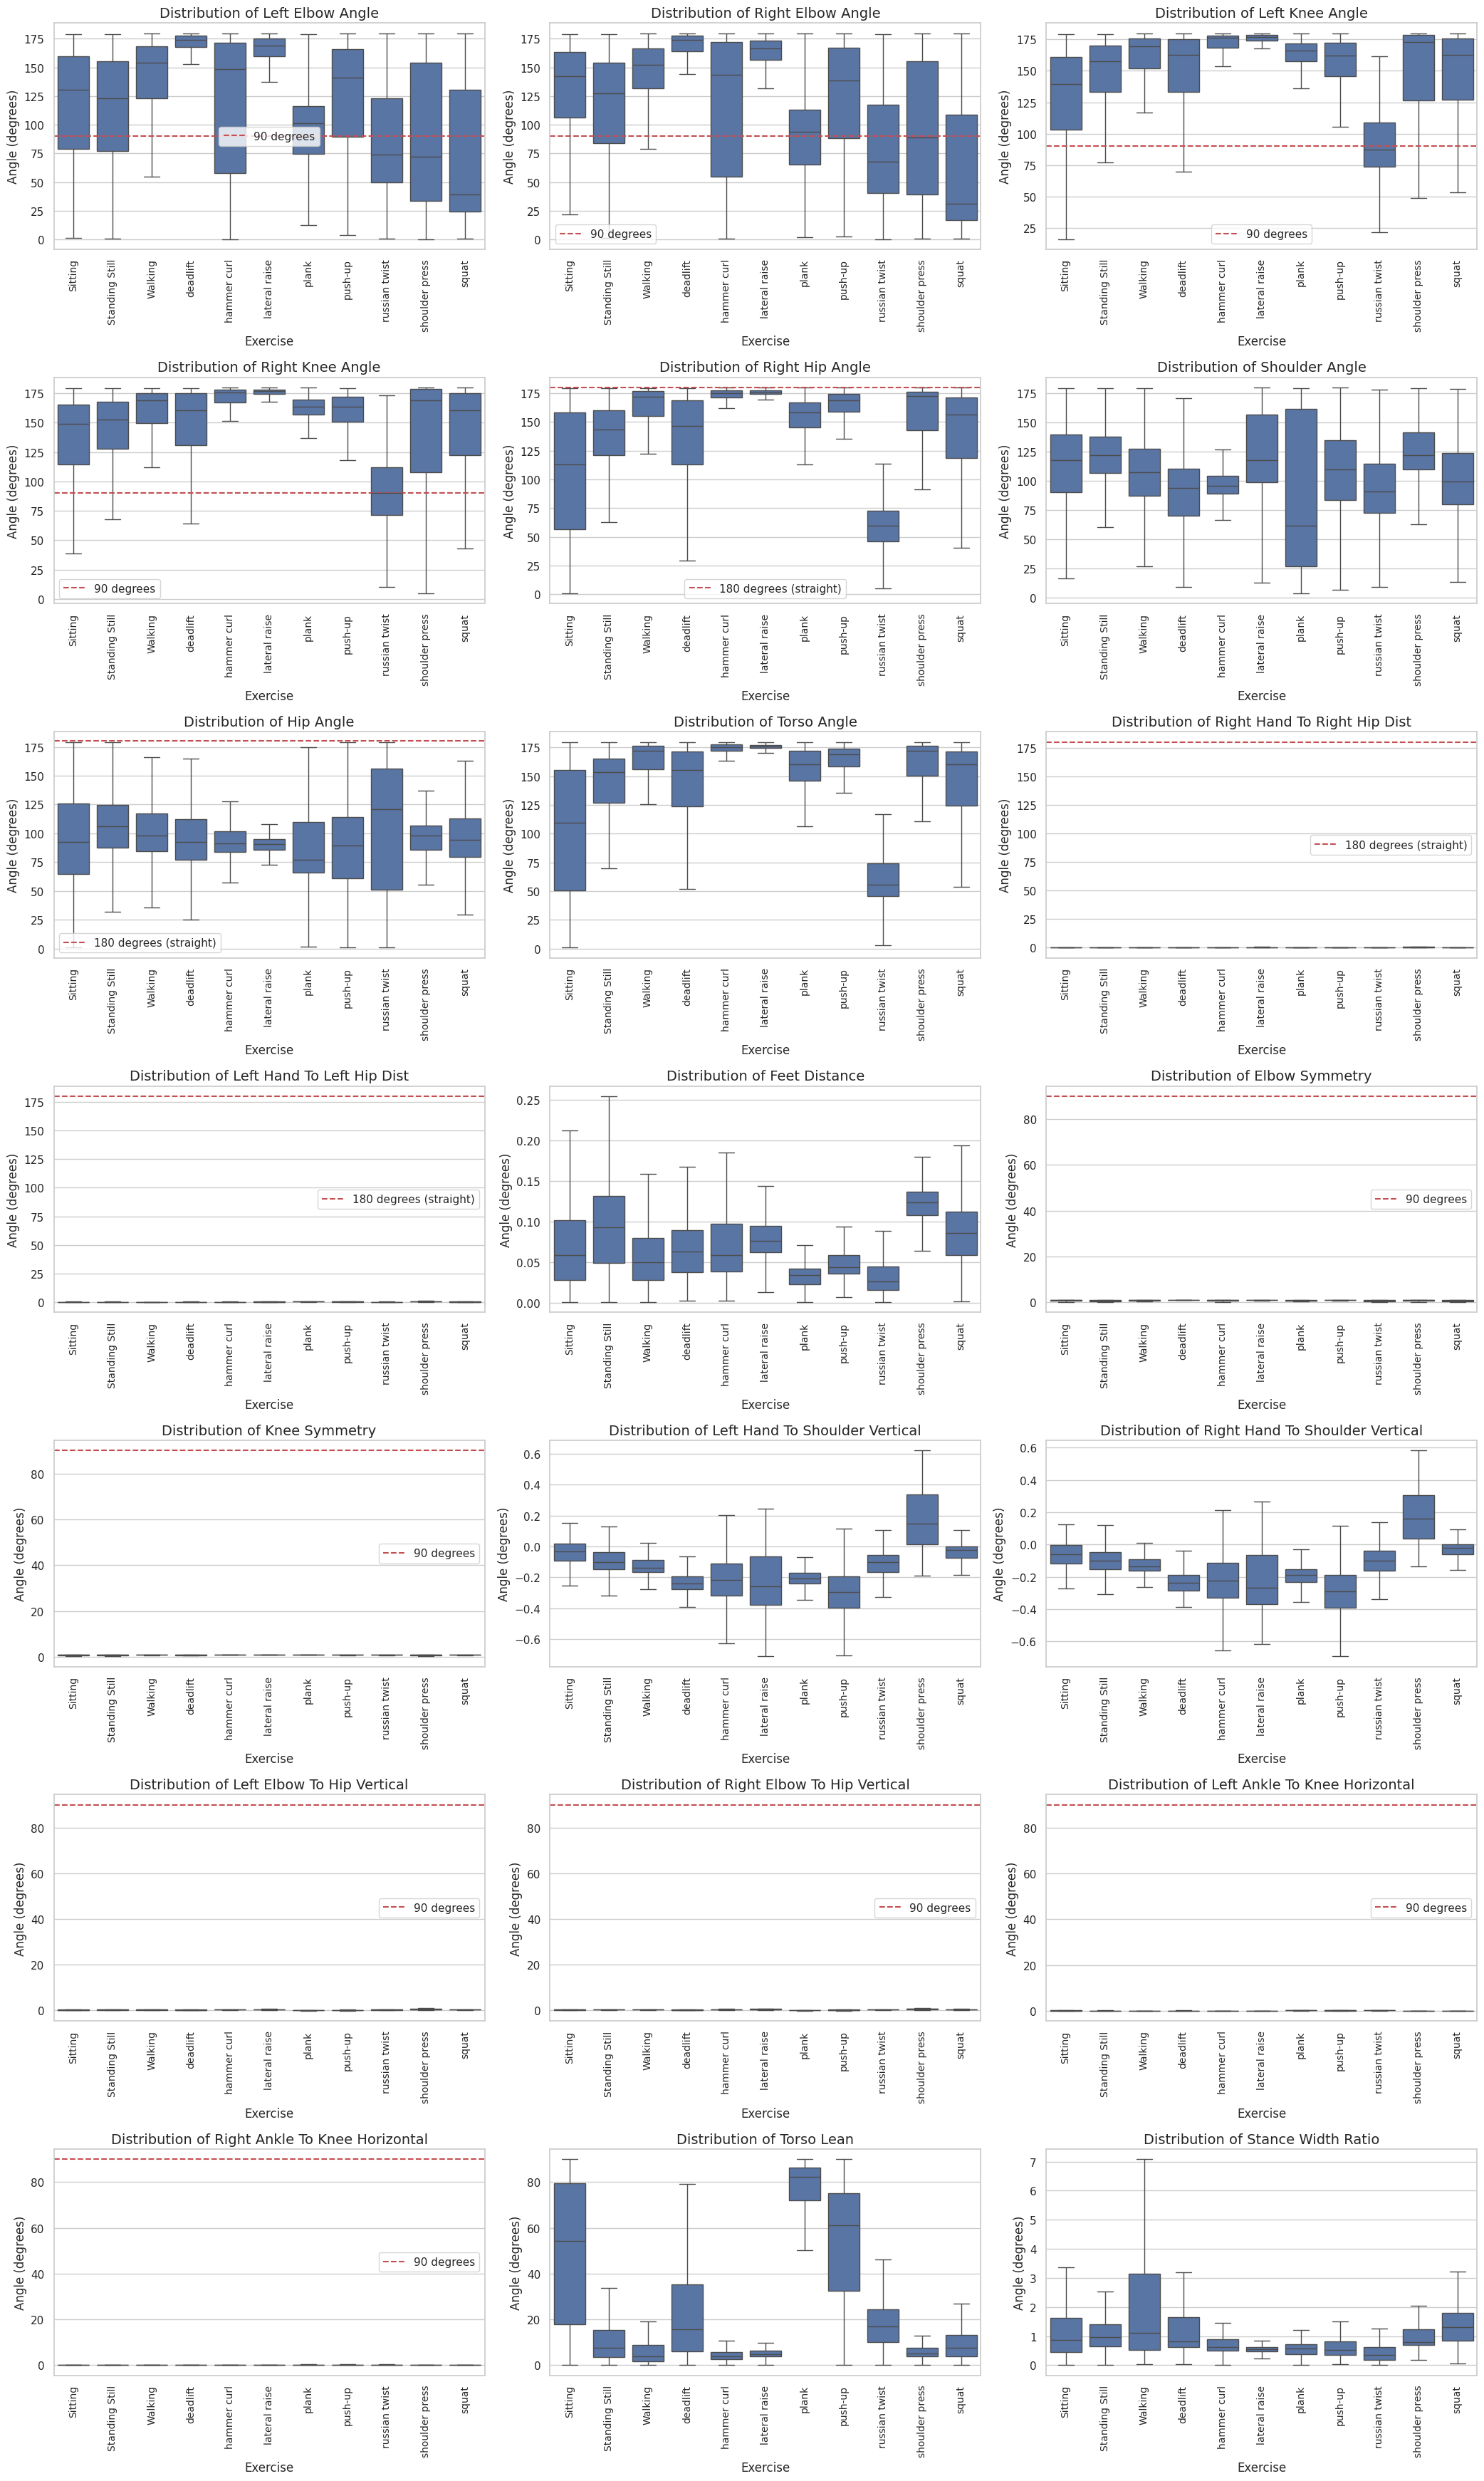

In [ ]:
sns.set(style="whitegrid")

num_angles = len(angle_columns)
cols = 3
rows = (num_angles + cols - 1) // cols

fig, axes = plt.subplots(rows, cols, figsize=(7 * cols, 5 * rows))
axes = axes.flatten() if rows > 1 or cols > 1 else [axes]

for i, angle_name in enumerate(angle_columns):
    ax = axes[i]

    sns.boxplot(x='label', y=angle_name, data=df_train, ax=ax)

    ax.set_title(f'Distribution of {angle_name.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel('Exercise', fontsize=12)
    ax.set_ylabel('Angle (degrees)', fontsize=12)
    ax.tick_params(axis='x', rotation=90, labelsize=10)

    if "elbow" in angle_name or "knee" in angle_name:
         ax.axhline(y=90, color='r', linestyle='--', linewidth=1.5, label='90 degrees')
         ax.legend()
    elif "hip" in angle_name:
        ax.axhline(y=180, color='r', linestyle='--', linewidth=1.5, label='180 degrees (straight)')
        ax.legend()

for i in range(len(angle_columns), len(axes)):
    fig.delaxes(axes[i])

plt.tight_layout()
plt.show()


## Reshaping Data

In [14]:
seq_length = 25
overlap= 13

In [15]:
def create_sequences_by_video(df, seq_length, overlap):
    X, y = [], []
    grouped_by_video = df.groupby(['label', 'video_id'])

    for (label, video_id), group in tqdm(grouped_by_video, desc="Creating Sequences"):
        data = group.drop(['label', 'video_id'], axis=1).values
        if len(data) < seq_length:
            continue

        for i in range(0, len(data) - seq_length + 1, seq_length - overlap):
            X.append(data[i:i + seq_length])
            y.append(label)

    X = np.array(X)
    y = np.array(y)
    return X, y

In [16]:
X_train, y_train_str = create_sequences_by_video(df_train, seq_length, overlap)
X_val, y_val_str = create_sequences_by_video(df_val, seq_length, overlap)
X_test, y_test_str = create_sequences_by_video(df_test, seq_length, overlap)

Creating Sequences: 100%|██████████| 34/34 [00:00<00:00, 1544.39it/s]


In [17]:
X_train.shape, X_val.shape, X_test.shape

((1279, 25, 21), (489, 25, 21), (155, 25, 21))

## Resampling

In [18]:
from imblearn.over_sampling import RandomOverSampler
n_sequences = X_train.shape[0]
X_train_flat = X_train.reshape(n_sequences, -1)

In [19]:
ros = RandomOverSampler(sampling_strategy='not majority', random_state=42)
X_train_resampled_flat, y_train_resampled = ros.fit_resample(X_train_flat, y_train_str)

In [20]:
X_train_resampled = X_train_resampled_flat.reshape(-1, seq_length, X_train.shape[2])

In [21]:
X_train_resampled.shape, y_train_resampled.shape

((2040, 25, 21), (2040,))

In [22]:
X_train = X_train_resampled
y_train_str = y_train_resampled

## Augmentation

In [ ]:
def augment_sequences(X, y, n_augments=1):
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # Jittering (Adding Gaussian Noise)
        noise = np.random.normal(0, 0.05, X_aug.shape)
        X_aug += noise

        # Scaling
        scale_factor = np.random.uniform(0.9, 1.1, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)

    return X_augmented, y_augmented


In [ ]:
X_train_aug, y_train_aug_str = augment_sequences(X_train, y_train_str, n_augments=2)

In [ ]:
X_train_aug.shape

(5610, 25, 21)

In [23]:
from scipy.interpolate import interp1d
def augment_sequences_robust(X, y, n_augments=2):
    X_augmented_list = [X]
    y_augmented_list = [y]

    for _ in range(n_augments):
        X_aug = X.copy()

        # 1. Jittering (Adds random noise)
        noise = np.random.normal(0, 0.05, X_aug.shape)
        X_aug += noise

        # 2. Scaling (Simulates body size or camera distance changes)
        scale_factor = np.random.uniform(0.9, 1.1, size=(X_aug.shape[0], 1, 1))
        X_aug *= scale_factor

        # 3. Random Rotation (Simulates pose variations)
        # Note: This is a simple 2D rotation. For 3D skeleton data, a more complex 3D rotation matrix would be needed.
        angle_rad = np.random.uniform(-0.1, 0.1, size=(X_aug.shape[0], 1, 1))  # +/- ~5.7 degrees
        cos_val = np.cos(angle_rad)
        sin_val = np.sin(angle_rad)

        # Apply a 2D rotation matrix to each frame of each sequence
        for i in range(X_aug.shape[0]):
            rotation_matrix = np.array([[cos_val[i], -sin_val[i]],
                                        [sin_val[i],  cos_val[i]]]).squeeze()

            # Assuming features are structured as pairs (e.g., x, y coordinates).
            # If you are using angles/distances, you can skip this step or apply a different type of rotation.
            for j in range(X_aug.shape[2] // 2):
                original_xy = X_aug[i, :, 2*j:2*j+2]
                rotated_xy = np.dot(original_xy, rotation_matrix)
                X_aug[i, :, 2*j:2*j+2] = rotated_xy

        # 4. Time Warping (Simulates speed changes)
        for i in range(X_aug.shape[0]):
            seq_len = X_aug.shape[1]
            time_points = np.linspace(0, 1, seq_len)

            # Create random time points for warping
            warp_points = np.sort(np.random.uniform(0, 1, size=2))
            warp_factor = np.random.uniform(0.8, 1.2, size=1)

            # Warp the sequence
            warped_time_points = time_points.copy()
            warped_time_points[np.where((time_points >= warp_points[0]) & (time_points <= warp_points[1]))] *= warp_factor

            # Interpolate to get the new sequence
            interp_func = interp1d(warped_time_points, X_aug[i, :, :], axis=0, fill_value="extrapolate")
            X_aug[i, :, :] = interp_func(time_points)

        # 5. Feature Masking (Simulates occlusion)
        for i in range(X_aug.shape[0]):
            num_features_to_mask = np.random.randint(0, X_aug.shape[2] // 4)
            if num_features_to_mask > 0:
                mask_features = np.random.choice(X_aug.shape[2], num_features_to_mask, replace=False)

                mask_start = np.random.randint(0, X_aug.shape[1] // 2)
                mask_end = np.random.randint(mask_start, X_aug.shape[1])

                X_aug[i, mask_start:mask_end, mask_features] = 0

        X_augmented_list.append(X_aug)
        y_augmented_list.append(y)

    X_augmented = np.concatenate(X_augmented_list, axis=0)
    y_augmented = np.concatenate(y_augmented_list, axis=0)

    return X_augmented, y_augmented

X_train_aug, y_train_aug_str = augment_sequences_robust(X_train, y_train_str, n_augments=2)

In [24]:
X_train_aug.shape

(6120, 25, 21)

### Scaling Data

In [25]:
from sklearn.preprocessing import StandardScaler
import joblib

In [26]:
features = [col for col in df_train.columns if col not in ['label', 'video_id']]

In [27]:
X_train_reshaped = X_train_aug.reshape(-1, X_train_aug.shape[-1])
X_val_reshaped = X_val.reshape(-1, X_val.shape[-1])
X_test_reshaped = X_test.reshape(-1, X_test.shape[-1])

In [28]:
scaler = StandardScaler()
scaler.fit(X_train_reshaped)

X_train_scaled = scaler.transform(X_train_reshaped)
X_val_scaled = scaler.transform(X_val_reshaped)
X_test_scaled = scaler.transform(X_test_reshaped)

X_train_final = X_train_scaled.reshape(X_train_aug.shape)
X_val_final = X_val_scaled.reshape(X_val.shape)
X_test_final = X_test_scaled.reshape(X_test.shape)

joblib.dump(scaler, 'real_time_scaler.pkl')

['real_time_scaler.pkl']

In [29]:
print(f"Final X_train shape for GRU: {X_train_final.shape}")
print(f"Final X_val shape for GRU: {X_val_final.shape}")
print(f"Final X_test shape for GRU: {X_test_final.shape}")

Final X_train shape for GRU: (6120, 25, 21)
Final X_val shape for GRU: (489, 25, 21)
Final X_test shape for GRU: (155, 25, 21)


## Encoding

In [30]:
from sklearn.preprocessing import LabelEncoder

In [31]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train_aug_str)
y_val_encoded = label_encoder.transform(y_val_str)
y_test_encoded = label_encoder.transform(y_test_str)

In [32]:
import json
label_mapping = {i: label for i, label in enumerate(label_encoder.classes_)}

with open('encoded_labels.json', 'w') as f:
    json.dump(label_mapping, f)

In [33]:
label_mapping

{0: np.str_('Sitting'),
 1: np.str_('Standing Still'),
 2: np.str_('Walking'),
 3: np.str_('bench press'),
 4: np.str_('deadlift'),
 5: np.str_('hammer curl'),
 6: np.str_('lateral raise'),
 7: np.str_('plank'),
 8: np.str_('push-up'),
 9: np.str_('russian twist'),
 10: np.str_('shoulder press'),
 11: np.str_('squat')}

# GRU BUILDING

In [34]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout, Bidirectional, BatchNormalization, LSTM,Conv1D, MaxPooling1D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import regularizers

In [35]:
num_features = X_train_aug.shape[2]
num_classes = len(np.unique(y_train_encoded))

# GRU_model_4.h5
model = Sequential()
model.add(tf.keras.Input(shape=(seq_length, num_features)))
model.add(Bidirectional(GRU(64, return_sequences=True)))
model.add(Dropout(0.3))
model.add(GRU(32))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(num_classes, activation='softmax'))


# model = Sequential()
# model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(seq_length, num_features)))
# model.add(MaxPooling1D(pool_size=2))
# model.add(Dropout(0.3))
# model.add(GRU(64))
# model.add(Dropout(0.3))
# model.add(Dense(32, activation='relu'))
# model.add(Dense(num_classes, activation='softmax'))

In [36]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=optimizer,
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [37]:
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True,
    min_delta=0.001,
    mode = 'min'
)

In [38]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=0.00001,
    verbose=1
)

In [39]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ bidirectional (Bidirectional)   │ (None, 25, 128)        │        33,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 25, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 32)             │        15,552 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 12)             │           396 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,676 (209.67 KB)

 Trainable params: 53,612 (209.42 KB)

 Non-trainable params: 64 (256.00 B)

In [40]:
epochs = 120
batch_size = 32

In [41]:
history = model.fit(
    X_train_final,
    y_train_encoded,
    epochs=epochs,
    batch_size=batch_size,
    validation_data=(X_val_final, y_val_encoded),
    callbacks=[early_stopping,reduce_lr]
)

Epoch 1/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.1068 - loss: 2.6655 - val_accuracy: 0.2761 - val_loss: 2.2954 - learning_rate: 1.0000e-04
Epoch 2/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.1986 - loss: 2.2999 - val_accuracy: 0.5133 - val_loss: 1.9682 - learning_rate: 1.0000e-04
Epoch 3/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3103 - loss: 2.0541 - val_accuracy: 0.6258 - val_loss: 1.6641 - learning_rate: 1.0000e-04
Epoch 4/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.3891 - loss: 1.8532 - val_accuracy: 0.6646 - val_loss: 1.4028 - learning_rate: 1.0000e-04
Epoch 5/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - accuracy: 0.4355 - loss: 1.6906 - val_accuracy: 0.6789 - val_loss: 1.2175 - learning_rate: 1.0000e-04
Epoch 6/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.4966 - loss: 1.5285 - val_accuracy: 0.6994 - val_loss: 1.0927 - learning_rate: 1.0000e-04
Epoch 7/120
192/192 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/ste

Since Our Validation Set is very small as compare to our augmented training set, so this much isnt considered as overfitting

## Evaluating Model

In [42]:
from sklearn.metrics import classification_report

In [43]:
from sklearn.metrics import classification_report
import json

y_pred = model.predict(X_val_final)
if y_pred.ndim > 1:
    y_pred = y_pred.argmax(axis=1)

if y_val_encoded.ndim > 1:
    y_val_encoded = y_val_encoded.argmax(axis=1)

print(
    classification_report(
        y_val_encoded,
        y_pred,
        labels=list(label_mapping.keys()),
        target_names=list(label_mapping.values())
    )
)


16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
                precision    recall  f1-score   support

       Sitting       0.51      0.66      0.57        35
Standing Still       0.65      0.83      0.73        18
       Walking       0.94      1.00      0.97        46
   bench press       0.44      0.74      0.55        47
      deadlift       0.69      0.33      0.45        33
   hammer curl       0.92      0.98      0.95        45
 lateral raise       0.96      0.75      0.84        36
         plank       0.92      0.94      0.93        51
       push-up       1.00      0.93      0.96        81
 russian twist       0.94      0.87      0.90        38
shoulder press       1.00      0.62      0.77        24
         squat       0.78      0.51      0.62        35

      accuracy                           0.80       489
     macro avg       0.81      0.76      0.77       489
  weighted avg       0.83      0.80      0.80       489



In [44]:
print("Evaluating on test data...")
loss, accuracy = model.evaluate(X_test_final, y_test_encoded)
print(f"Test Loss: {loss:.4f}")
print(f"Test Accuracy: {accuracy:.4f}")

Evaluating on test data...
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3822 - loss: 2.2954 
Test Loss: 2.7407
Test Accuracy: 0.3355


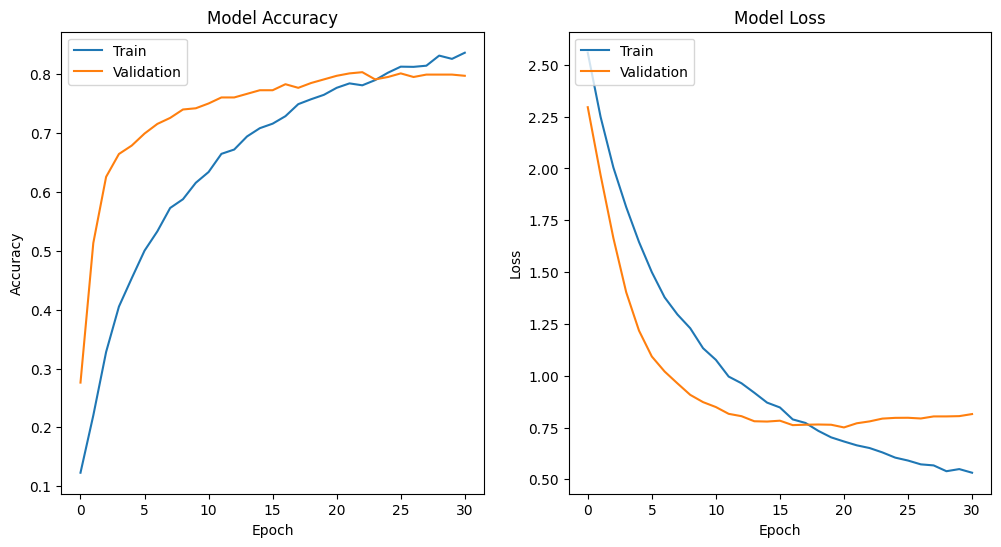

In [47]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [48]:
model.save('GRU_model_7.h5')

## Using ML APPROACH

1.  Random Forest Classifier
2.  Light GBM



In [ ]:
X_train_flat = X_train_final.reshape(X_train_final.shape[0], -1)
X_val_flat = X_val_final.reshape(X_val_final.shape[0], -1)
X_test_flat = X_test_final.reshape(X_test_final.shape[0], -1)

print(f"Flattened training data shape: {X_train_flat.shape}")
print(f"Flattened validation data shape: {X_val_flat.shape}")
print(f"Flattened test data shape: {X_test_flat.shape}")

Flattened training data shape: (2505, 525)
Flattened validation data shape: (343, 525)
Flattened test data shape: (113, 525)


In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

### Using Class Balancing

In [ ]:
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(y_train_encoded),
    y=y_train_encoded
)
class_weight_dict = dict(enumerate(class_weights))

In [ ]:
rfc = RandomForestClassifier(
    n_estimators=100,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1 #
)

print("Training Random Forest Classifier...")
rfc.fit(X_train_flat, y_train_encoded)

Training Random Forest Classifier...


RandomForestClassifier(class_weight={0: np.float64(1.4910714285714286),
                                     1: np.float64(0.7198275862068966),
                                     2: np.float64(1.4910714285714286),
                                     3: np.float64(0.6139705882352942),
                                     4: np.float64(0.9236725663716814),
                                     5: np.float64(1.410472972972973),
                                     6: np.float64(2.4851190476190474),
                                     7: np.float64(0.6912251655629139)},
                       n_jobs=-1, random_state=42)

In [ ]:
val_preds = rfc.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")


Validation Accuracy: 0.8455


In [ ]:
print("\nValidation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Classification Report:
              precision    recall  f1-score   support

           0       0.62      0.64      0.63        33
           1       0.76      1.00      0.87        45
           2       1.00      0.61      0.76        36
           3       0.77      0.96      0.85        51
           4       1.00      0.94      0.97        81
           5       0.97      0.92      0.95        38
           6       1.00      0.62      0.77        24
           7       0.73      0.77      0.75        35

    accuracy                           0.85       343
   macro avg       0.86      0.81      0.82       343
weighted avg       0.87      0.85      0.84       343



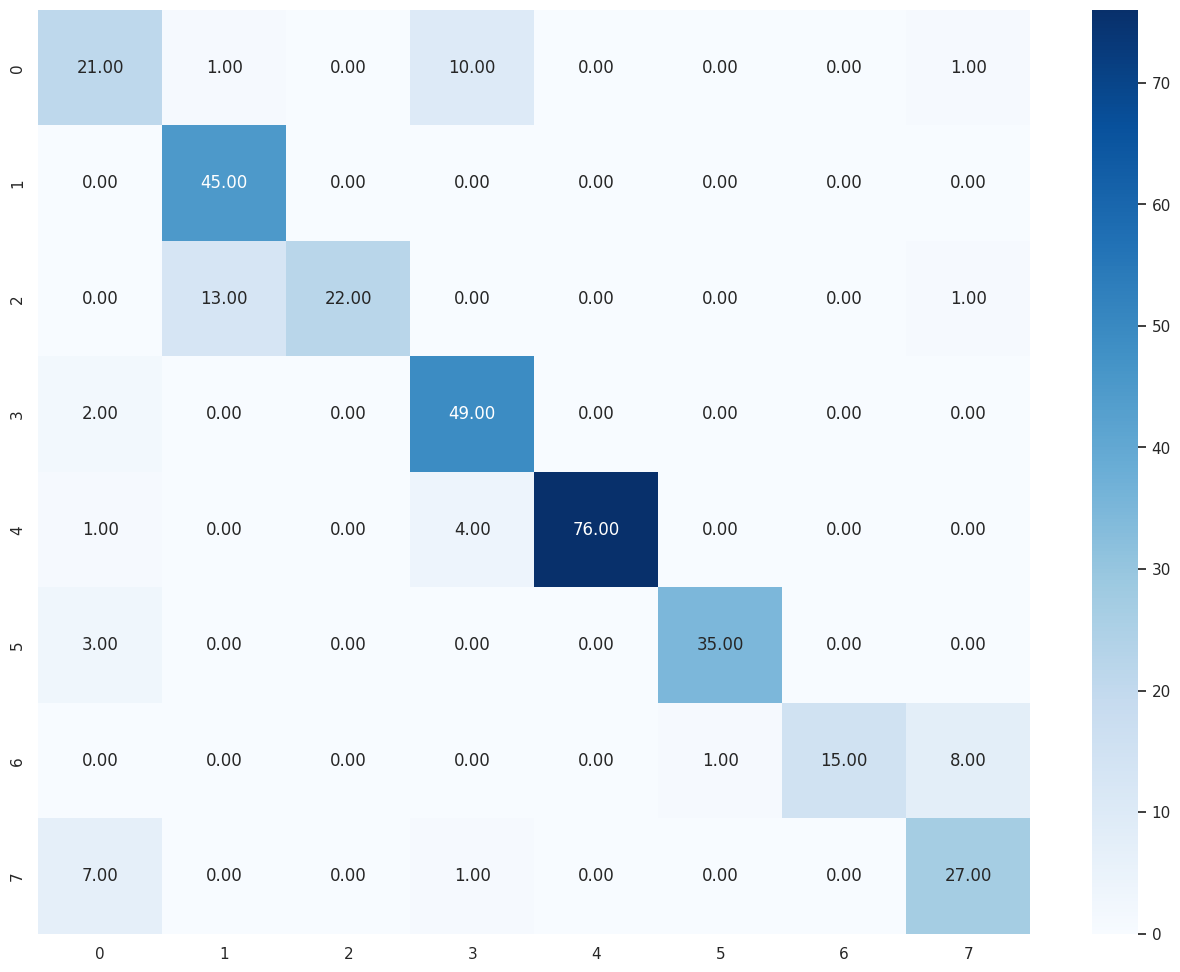

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [ ]:
test_preds = rfc.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.5221


## Light GBM

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

In [ ]:
lgb_model = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(np.unique(y_train_encoded)),
    n_estimators=100,
    learning_rate=0.1,
    class_weight=class_weight_dict,
    random_state=42,
    n_jobs=-1,
    verbose=-1
)

print("Training LightGBM Classifier...")
lgb_model.fit(X_train_flat, y_train_encoded)
print("Training complete.")

Training LightGBM Classifier...
Training complete.


In [ ]:
val_preds = lgb_model.predict(X_val_flat)
val_accuracy = accuracy_score(y_val_encoded, val_preds)
print(f"\nValidation Accuracy: {val_accuracy:.4f}")
print("Validation Classification Report:")
print(classification_report(y_val_encoded, val_preds))


Validation Accuracy: 0.8513
Validation Classification Report:
              precision    recall  f1-score   support

           0       0.71      0.36      0.48        33
           1       0.80      1.00      0.89        45
           2       1.00      0.67      0.80        36
           3       0.89      0.98      0.93        51
           4       0.97      0.93      0.95        81
           5       0.81      1.00      0.89        38
           6       0.89      0.71      0.79        24
           7       0.66      0.89      0.76        35

    accuracy                           0.85       343
   macro avg       0.84      0.82      0.81       343
weighted avg       0.86      0.85      0.84       343



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


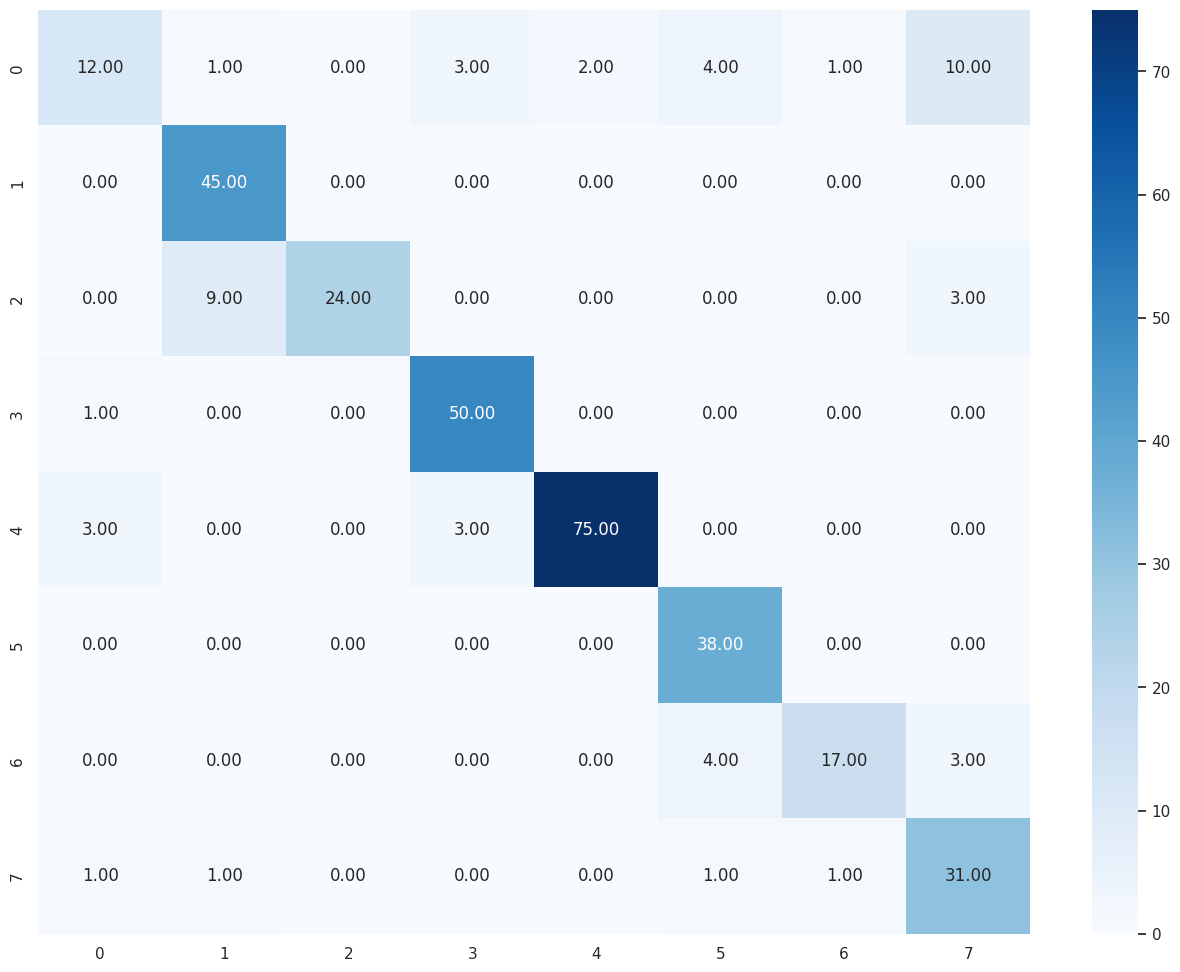

In [ ]:
plt.figure(figsize=(16,12))
sns.heatmap(confusion_matrix(y_val_encoded, val_preds), cmap='Blues', annot=True, fmt=".2f")
plt.show()

In [ ]:
test_preds = lgb_model.predict(X_test_flat)
test_accuracy = accuracy_score(y_test_encoded, test_preds)
print(f"\nTest Accuracy: {test_accuracy:.4f}")
print("Test Classification Report:")
print(classification_report(y_test_encoded, test_preds))


Test Accuracy: 0.4690
Test Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.34      0.50        47
           1       0.50      0.14      0.22         7
           2       0.00      0.00      0.00         5
           3       0.38      0.62      0.48         8
           4       0.83      1.00      0.91        10
           5       0.17      0.44      0.25         9
           6       0.60      0.43      0.50        14
           7       0.35      0.85      0.50        13

    accuracy                           0.47       113
   macro avg       0.47      0.48      0.42       113
weighted avg       0.65      0.47      0.48       113



/usr/local/lib/python3.12/dist-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
